<a href="https://colab.research.google.com/github/Majd100002/2D-to-3D-Human/blob/main/my_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# ✅ فك ضغط البيانات في كل مرة عند تشغيل الكود
!unzip "/content/drive/MyDrive/celeba/celeb_Data" -d /content/celeba/

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

In [ ]:
#Specify the correct data path in Google Drive
data_path = "/content/celeba/img_align_celeba/img_align_celeba"

#  Create a list of all images in the folder
image_paths = [os.path.join(data_path, img) for img in os.listdir(data_path) if img.endswith(".jpg")]
np.random.shuffle(image_paths)

In [ ]:
#  Data Splitting
train_size = int(0.8 * len(image_paths))
val_size = int(0.1 * len(image_paths))
test_size = len(image_paths) - train_size - val_size

train_paths = image_paths[:train_size]
val_paths = image_paths[train_size:train_size + val_size]
test_paths = image_paths[train_size + val_size:]


In [ ]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


In [ ]:
# Load MobileNetV2 for feature extraction
mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
mobilenet.trainable = False
feature_extractor = models.Model(inputs=mobilenet.input, outputs=[mobilenet.get_layer('block_13_expand_relu').output])

<ipython-input-7-211c5d2c9411>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Perceptual Loss Function
def perceptual_loss(y_true, y_pred):
    true_features = feature_extractor(y_true)
    pred_features = feature_extractor(y_pred)
    loss = tf.reduce_mean(tf.square(true_features - pred_features))
    return loss

In [ ]:
# Hybrid Loss Function
def hybrid_loss(y_true, y_pred):
    perceptual = perceptual_loss(y_true, y_pred)
    mae = K.mean(K.abs(y_true - y_pred))
    mse = K.mean(K.square(y_true - y_pred))
    return perceptual + 0.1 * mae + 0.1 * mse

In [ ]:
# Building U-Net with LeakyReLU
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x

    def upsample_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Concatenate()([x, skip])
        return x

    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    bn = conv_block(p3, 512)
    u1 = upsample_block(bn, c3, 256)
    c4 = conv_block(u1, 256)
    u2 = upsample_block(c4, c2, 128)
    c5 = conv_block(u2, 128)
    u3 = upsample_block(c5, c1, 64)
    c6 = conv_block(u3, 64)
    outputs = layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(c6)
    model = models.Model(inputs, outputs)
    return model

In [ ]:
#  Creating a Data Generator
class DataGenerator(Sequence):
    def __init__(self, data_path, batch_size=32, img_size=(256, 256), augment=False):
        self.files = [f for f in os.listdir(data_path) if f.endswith(".jpg")][:10000]
        self.data_path = data_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.files[index * self.batch_size:(index + 1) * self.batch_size]
        images, gray_images = [], []

        for filename in batch_files:
            img = cv2.imread(os.path.join(self.data_path, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256))
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = (img / 127.5) - 1
            gray = gray[..., np.newaxis] / 255.0
            images.append(img)
            gray_images.append(gray)
        return np.array(gray_images), np.array(images)

In [ ]:
# ✅ Run the training
train_gen = DataGenerator(data_path, batch_size=32, augment=True)
test_gen = DataGenerator(data_path, batch_size=32, augment=False)
model = build_unet((256, 256, 1))
model.compile(optimizer='adam', loss=hybrid_loss)
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
model.fit(train_gen, epochs=500, validation_data=test_gen, callbacks=callbacks)
model.save("colorization_model.h5")
print("✅ تم حفظ النموذج!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 166s 311ms/step - loss: 0.0802 - val_loss: 0.1687
Epoch 2/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 92s 294ms/step - loss: 0.0454 - val_loss: 0.0662
Epoch 3/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 84s 271ms/step - loss: 0.0450 - val_loss: 0.2070
Epoch 4/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 84s 270ms/step - loss: 0.0441 - val_loss: 0.0412
Epoch 5/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 92s 296ms/step - loss: 0.0429 - val_loss: 0.0411
Epoch 6/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 92s 296ms/step - loss: 0.0425 - val_loss: 0.0418
Epoch 7/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 92s 294ms/step - loss: 0.0425 - val_loss: 0.0412
Epoch 8/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 92s 294ms/step - loss: 0.0407 - val_loss: 0.0403
Epoch 9/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 84s 268ms/step - loss: 0.0405 - val_loss: 0.0505
Epoch 10/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 85s 273ms/step - loss: 0.0408 - val_loss: 0.0560
Epoch 11/500
312/312 ━━━━━━━━━━━━━━━━━━━━ 92s 295ms/step - loss: 0.0397 - val_loss: 0.0406
Epoch 1

✅ تم حفظ النموذج!


In [ ]:
def hybrid_loss(y_true, y_pred):
    perceptual = perceptual_loss(y_true, y_pred)
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    return 0.7 * perceptual + 0.3 * mse_loss

The model has been successfully downloaded!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


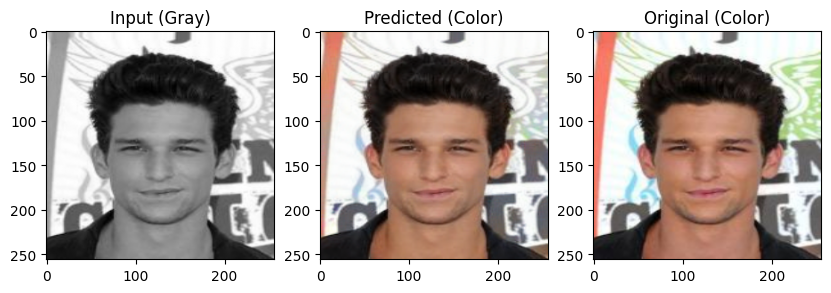

In [ ]:
import matplotlib.pyplot as plt

# ✅ Download the trained model
model = tf.keras.models.load_model("colorization_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

print("The model has been successfully downloaded!")


#  Select an image from the test
test_image_path = os.path.join(data_path, os.listdir(data_path)[0])

#  Load and transform the image
def load_test_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = gray[..., np.newaxis] / 255.0  # Transform to [0,1]

    img = (img / 127.5) - 1  # Transform the values to [-1,1]
    return np.expand_dims(gray, axis=0), img

gray_input, original_image = load_test_image(test_image_path)

#  Run the model to colorize the image
predicted_image = model.predict(gray_input)[0]

#  Transform the values from [-1,1] to [0,1]
predicted_image = (predicted_image + 1) / 2
predicted_image = np.clip(predicted_image, 0, 1)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray_input[0].squeeze(), cmap="gray")
plt.title("Input (Gray)")

plt.subplot(1, 3, 2)
plt.imshow(predicted_image)
plt.title("Predicted (Color)")

plt.subplot(1, 3, 3)
plt.imshow((original_image + 1) / 2)  # Ensure the values are transformed
plt.title("Original (Color)")

plt.show()


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import os
from tensorflow.keras.models import load_model

# ✅ تحميل النموذج المدرب
model = load_model("colorization_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

def test_images_from_drive():
    """اختبار النموذج على جميع الصور في مجلد black داخل Google Drive"""

    # ✅ ربط Google Drive بـ Google Colab
    drive.mount('/content/drive')

    # ✅ تحديد المسار إلى مجلد الصور داخل Google Drive
    folder_path = "/content/drive/MyDrive/black"

    # ✅ التحقق مما إذا كان المجلد موجودًا
    if not os.path.exists(folder_path):
        print("❌ خطأ: لم يتم العثور على المجلد! تأكد من صحة المسار.")
        return

    # ✅ الحصول على قائمة بجميع الصور داخل المجلد (JPG فقط)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

    if len(image_files) == 0:
        print("❌ لا توجد صور في المجلد!")
        return

    print(f"📂 عدد الصور التي سيتم اختبارها: {len(image_files)}")

    # ✅ معالجة كل صورة واحدة تلو الأخرى
    for image_name in image_files:
        image_path = os.path.join(folder_path, image_name)

        # ✅ تحميل الصورة وتحويلها إلى رمادي
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # تحويل الصورة إلى رمادي

        # ✅ تطبيع الصورة وتجهيزها للنموذج
        gray_input = gray[..., np.newaxis] / 255.0  # تحويل الرمادي إلى [0,1]
        img_input = np.expand_dims(gray_input, axis=0)  # إضافة بعد للدفعة

        # ✅ تشغيل النموذج لتلوين الصورة
        predicted_image = model.predict(img_input)[0]

        # ✅ تحويل القيم من [-1,1] إلى [0,1]
        predicted_image = (predicted_image + 1) / 2
        predicted_image = np.clip(predicted_image, 0, 1)

        # ✅ عرض النتائج
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(gray.squeeze(), cmap="gray")
        plt.title("Input (Gray)")

        plt.subplot(1, 3, 2)
        plt.imshow(predicted_image)
        plt.title("Predicted (Color)")

        plt.subplot(1, 3, 3)
        plt.imshow(img)
        plt.title("Original Image")

        plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 عدد الصور التي سيتم اختبارها: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


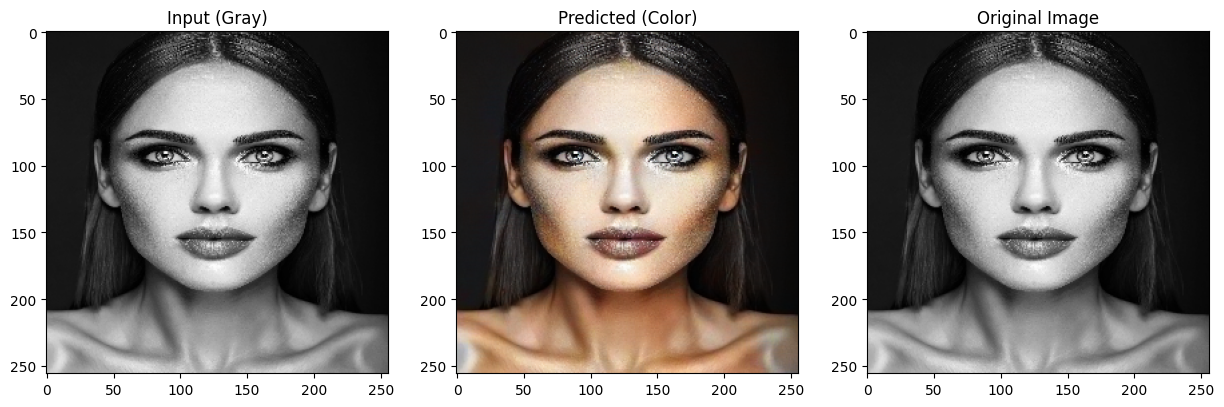

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


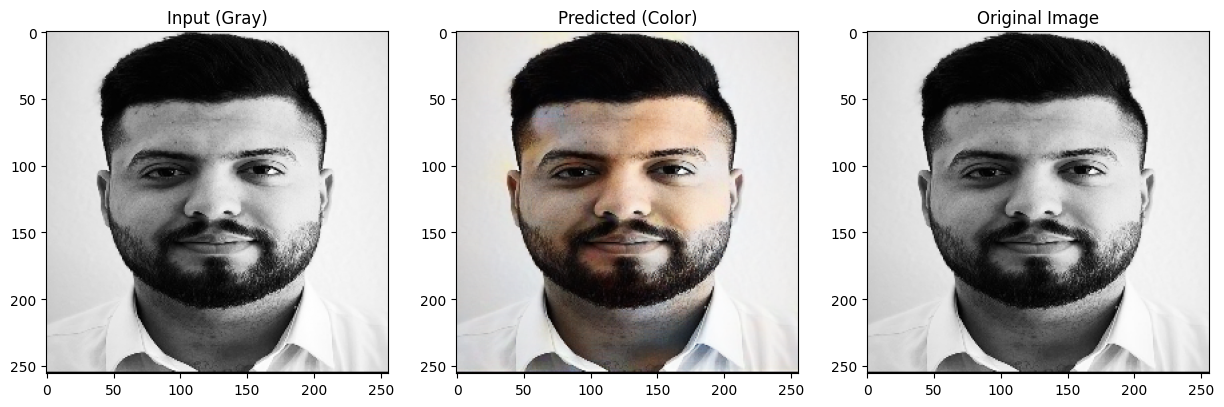

In [ ]:
test_images_from_drive()

In [ ]:
def test_single_image_from_drive(image_name):
    """اختبار صورة معينة داخل مجلد black داخل Google Drive"""

    # ✅ ربط Google Drive بـ Google Colab
    drive.mount('/content/drive')

    # ✅ تحديد المسار إلى مجلد الصور داخل Google Drive
    folder_path = "/content/drive/MyDrive/black"
    image_path = os.path.join(folder_path, image_name)

    # ✅ التحقق مما إذا كانت الصورة موجودة
    if not os.path.exists(image_path):
        print(f"❌ خطأ: لم يتم العثور على الصورة {image_name}! تأكد من صحة الاسم.")
        return

    # ✅ تحميل الصورة وتحويلها إلى رمادي
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # تحويل الصورة إلى رمادي

    # ✅ تطبيع الصورة وتجهيزها للنموذج
    gray_input = gray[..., np.newaxis] / 255.0  # تحويل الرمادي إلى [0,1]
    img_input = np.expand_dims(gray_input, axis=0)  # إضافة بعد للدفعة

    # ✅ تشغيل النموذج لتلوين الصورة
    predicted_image = model.predict(img_input)[0]  # تأكد من استخدام `[0]` بدلاً من `[5]`

    # ✅ تحويل القيم من [-1,1] إلى [0,1]
    predicted_image = (predicted_image + 1) / 2
    predicted_image = np.clip(predicted_image, 0, 1)

    # ✅ عرض النتائج
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(gray.squeeze(), cmap="gray")
    plt.title("Input (Gray)")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image)
    plt.title("Predicted (Color)")

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.title("Original Image")

    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


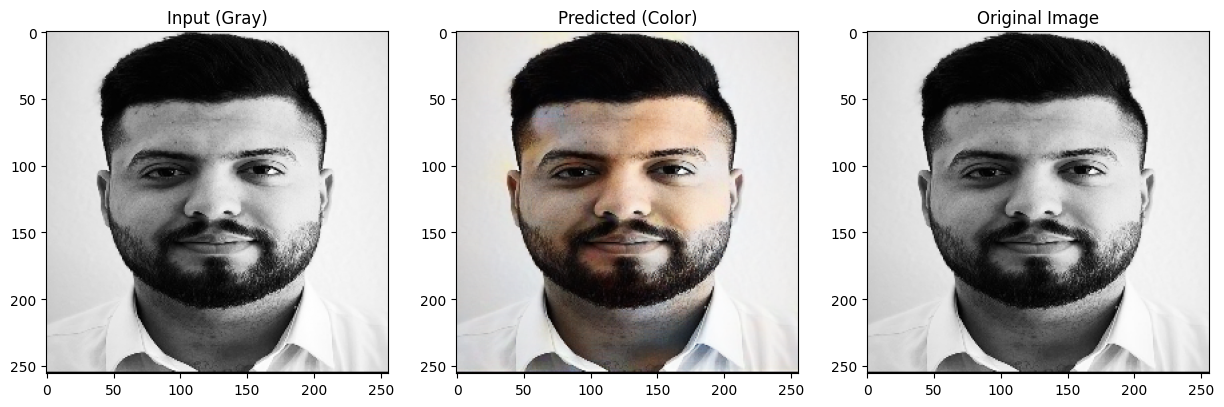

In [ ]:
test_single_image_from_drive("aboud.jpg")  # ضع اسم الصورة هنا


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


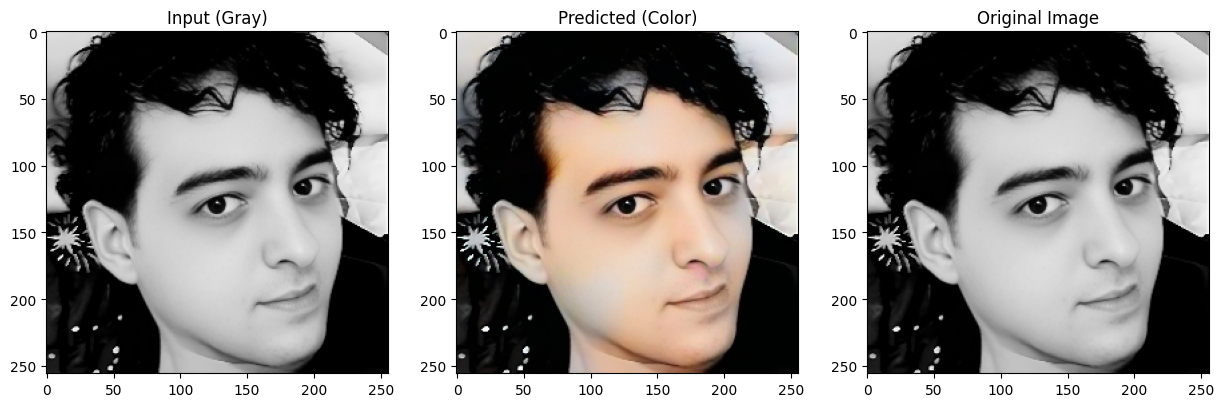

In [ ]:

test_single_image_from_drive("abobkr.png")  # ضع اسم الصورة هنا
